## Validating the model's performance on user specified stocks and date range

In [1]:
import neat
import pandas as pd
import numpy as np
import datetime
import brain
import pickle
from stock_class import Stock
from portfolio_class import Portfolio
import random
import pprint
import matplotlib.pyplot as plt

### Load historical datasets

In [2]:
with open("validation.pickle", "rb") as f:
        validation = pickle.load(f)
    
with open("spy.pickle", "rb") as f:
        spy = pickle.load(f)

### Selecting a subset of stocks and a date range

In [12]:
# Set a start date (2022-5-16 is the earliest available in the validation dataframe)
start_date = datetime.date(2022,7,16)
# Set an end date (2022-10-24 is the latest available in the validation dataframe)
end_date = datetime.date(2022,9,15)
# Set how many stocks to consider for buying/selling every day
num_selected = 100

# Set starting cash
cash = 1000

# Random sample num_selected amount from the available stocks in the dataset
stocks_in_the_dataset = validation['ticker'].unique()
subset_of_stocks = random.choices(stocks_in_the_dataset, k=num_selected)
pp = pprint.PrettyPrinter(width=90, compact=True)
print(f'Selected stocks that will be considered for trading between {start_date} -- {end_date} are: ')
print(" ")
pp.pprint(subset_of_stocks)

Selected stocks that will be considered for trading between 2022-07-16 -- 2022-09-15 are: 
 
['AMWD', 'NVRO', 'LOPE', 'AMWD', 'WK', 'WRK', 'VOR', 'DNOW', 'LYFT', 'TRU', 'NWBI',
 'HLNE', 'WIX', 'LEGN', 'BLKB', 'TBNK', 'AZPN', 'CVAC', 'BIT', 'JRI', 'BGB', 'BGB',
 'BFIN', 'TRU', 'AGYS', 'GLOV', 'BGH', 'LEVI', 'ONEM', 'NLSN', 'CIM', 'MASS', 'REYN',
 'HLNE', 'XBIT', 'ONEM', 'CC', 'AMKR', 'CC', 'INN', 'BITI', 'AROW', 'WIX', 'PMT', 'VIR',
 'MNTK', 'ASML', 'TIL', 'ZIM', 'FPAC', 'AY', 'ROOT', 'SAGE', 'CRSR', 'TERN', 'NOA',
 'AVIR', 'TPIC', 'AMGN', 'MGNX', 'IVR', 'IGT', 'FPAC', 'SFBS', 'PLNT', 'CSTE', 'THQ',
 'INN', 'MDB', 'PRLB', 'SOI', 'BSTZ', 'VIRT', 'NDLS', 'G', 'PEN', 'DNOW', 'TNDM', 'CFG',
 'ONEM', 'ZI', 'BSTZ', 'LESL', 'MDB', 'TDSC', 'CARR', 'IBP', 'APA', 'AIMC', 'AZPN',
 'AGCB', 'LI', 'CCS', 'SNOW', 'ANIK', 'TIMB', 'UPST', 'KAR', 'PBFX', 'APOG']


### Filter the requested stocks and dates

In [13]:
df_selected = validation[validation['ticker'].isin(subset_of_stocks) & 
                             validation['date_'].isin(
                                 [item.date() for item in list(pd.date_range(start=start_date, end=end_date))]
                             )]
df_selected.head(5)

,close,volume,ticker,sector,sma_9,sma_14,sma_20,sma_50,sma_100,sma_200,...,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
2022-07-18,243.839996,2231400.0,AMGN,Healthcare,246.789998,246.116427,244.610499,244.484200,241.86070,229.360500,...,0,0,0,0,0,1,0,0,0,0
2022-07-18,5.270000,74200.0,XBIT,Healthcare,5.452222,5.562857,5.630500,5.758200,7.28680,9.728175,...,0,0,0,0,0,1,0,0,0,0
2022-07-18,121.050003,322900.0,PEN,Healthcare,126.363331,126.628570,126.471999,134.123201,169.04910,210.948000,...,0,0,0,0,0,1,0,0,0,0
2022-07-18,9.390000,1444400.0,ONEM,Healthcare,10.252778,9.684643,9.366750,8.529500,9.14275,12.998425,...,0,0,0,0,0,1,0,0,0,0
2022-07-18,5.600000,167500.0,TIL,Healthcare,5.746667,5.401429,5.253000,5.908500,7.79835,12.390975,...,0,0,0,0,0,1,0,0,0,0


### Define the main loop

In [14]:
def main(best_genome_name, data, cash):
    
    with open(best_genome_name, "rb") as f:
        best_genome = pickle.load(f)
    
    # Load configuration.
    config_file = r'neat_config.txt'

    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # X_cols and portfolio_attributes
    X_cols = ['cat_1', 'cat_2', 'cat_3', 'Basic Materials', 'Communication Services',
              'Consumer Cyclical', 'Consumer Defensive', 'Energy',
              'Financial Services', 'Healthcare', 'Industrials', 'Real Estate',
              'Technology', 'Utilities', 'variance_100', 'variance_global']
    portfolio_attributes = ["proportion_invested", "entropy_stock", "entropy_sector"]

    # preprocessing
    training_data = data.copy()
    brain.shape_config_file(config_file, X_cols, portfolio_attributes)
    X_cols = [col.lower() for col in X_cols]
    
    threshold = 0.05

    # create 1-member population
    p = neat.Population(config)
    p.population = {1: best_genome}

    # clear and set Stocks
    Stock.clear_stock_list()
    Stock.set_each(training_data)

    # same loop as in brain.run_neat
    for genome_id, genome in p.population.items():
        genome.fitness = 0
        genome_portfolio = Portfolio(genome=genome, cash=cash)
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for current_date in training_data.index.unique():

            # shuffle
            random.shuffle(Stock.stock_list)
            for stock in Stock.stock_list:
                try:
                    df = stock.data.loc[current_date, X_cols]
                    for item in portfolio_attributes:
                        df[item] = genome_portfolio.__getattribute__(item)
                except KeyError:
                    continue
                output = net.activate(list(df))
                decision, proportion = brain.output_to_decision(output[0], threshold=threshold)
                if decision == 'buy':
                    amount = (proportion * genome_portfolio.cash_current) / stock.data.loc[current_date, "close"]
                    genome_portfolio.buy(stock=stock, amount=amount, as_of=current_date)
                elif decision == 'sell':
                    amount = -1 * (proportion * genome_portfolio.get_stock_amount(stock))
                    genome_portfolio.sell(stock=stock, amount=amount, as_of=current_date)
                elif not decision:
                    pass
                else:
                    raise NotImplementedError
            # End-of-day update
            genome_portfolio.update_balance_eod(as_of=current_date)
    
    print("Succesfully simulated trading.")
    return genome, genome_portfolio

### Calculate S&P 500 return during the selected period

In [15]:
first_close = spy.loc[spy.index.date == df_selected.index[0], "Close"]
last_close = spy.loc[spy.index.date == df_selected.index[-1], "Close"]
spy_return = last_close[0] / first_close[0]
print(f"S&P500 total return between {start_date} & {end_date}: ")
print(round(spy_return,4))

S&P500 total return between 2022-07-16 & 2022-09-15: 
1.0214


### Simulate trading

In [16]:
# Set the best genome
best_genome_name = "best_genome_123.pickle"

# Run main
genome, portfolio = main(best_genome_name=best_genome_name, data=df_selected, cash=cash)

Succesfully simulated trading.


### Calculate our startegy's return

In [17]:
print(f"Total return of trading bot between {start_date} & {end_date} only trading selected stocks: ")
print(round((portfolio.total_portfolio_value_hist[-1][1] / cash), 4))

Total return of trading bot between 2022-07-16 & 2022-09-15 only trading selected stocks: 
1.5023


### Visualize the difference between S&P500 and our trading strategy

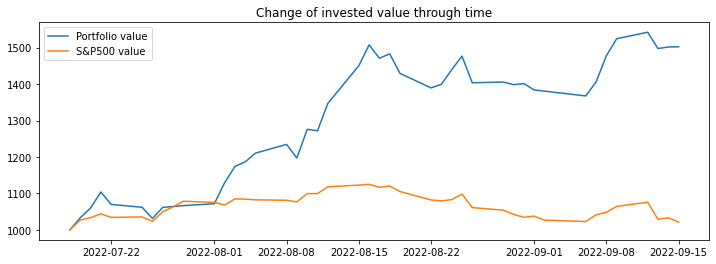

In [18]:
# Create two separate variables from list of tulples
dates = []
profits = []
for item in portfolio.total_portfolio_value_hist:
    dates.append(item[0])
    profits.append(item[1])

# Calculate the change of S&P500 standardized to match our starting cash    
spy_selected = spy[spy.index.isin([item.date() for item in list(pd.date_range(start=start_date, end=end_date))])]
spy_selected['Value'] = np.nan
spy_selected['Value'][0] = cash
for i in range(1,len(spy_selected['Value'])):
    spy_selected['Value'][i] = spy_selected['Return'][i] * spy_selected['Value'][i-1]

# Create plot
plt.figure(figsize=(12,4))
plt.title("Change of invested value through time")
plt.plot(dates, profits, label="Portfolio value")
plt.plot(dates, spy_selected["Value"], label="S&P500 value" )
plt.legend()

### Final portfolio

In [10]:
portfolio.balance.head(portfolio.balance.last_valid_index())

,stock_name,amount,price,value,sector
0,OLMA,35.374510,2.860000,101.171095,Healthcare
1,BITI,0.007628,38.759998,0.295647,Unknown
2,LEGN,0.386092,39.750000,15.347143,Healthcare
3,ASML,0.007329,379.130005,2.778833,Technology
4,ALGN,0.003429,201.630005,0.691487,Healthcare
5,XM,0.207936,9.830000,2.044014,Technology
6,SEMI,0.894374,13.668000,12.224301,Unknown
7,CSTL,0.003193,22.020000,0.070304,Healthcare
8,ALPN,3.572917,7.100000,25.367709,Healthcare
9,ACTG,0.004969,3.750000,0.018634,Industrials
